<center><h1>Time Series Classification(2)</h1></center>
<br>
<br>

Name: Chengyi Li
<br>
Github Username: ChengyiLi98
<br>

## 1. Time Series Classification Part 1: Feature Creation/Extraction (Continue)

### (a) Obtain Data

Import packages

In [49]:
import os
import csv
import numpy as np
import pandas as pd
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import math
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE  # scikit-learn version to be 1.2.2, not the latest one

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Get the AReM Data Set

In [2]:
main_path = '../data/ArEM/'
file_list = os.listdir(main_path)
file_list

['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']

In [3]:
values = [7,6,15,15,15,15,15]
folders = dict(zip(file_list, values))

paths =[]
for folder in folders:
    for num in range(1, folders[folder] + 1):
        path = main_path + folder + '/dataset' + str(num) + '.csv'
        paths.append(path)
# paths will be the list of the paths of all the datasets

### (b) Splitting Data

In [5]:
test_path =[]
test_paths =[]

for folder in file_list[:2]:
    for num in range(1,3):
        test_path = main_path + folder + '/dataset' + str(num) + '.csv'
        test_paths.append(test_path)

for folder in file_list[2:]:
    for num in range(1,4):
        test_path = main_path + folder + '/dataset' + str(num) + '.csv'
        test_paths.append(test_path)

test_paths

['../data/ArEM/bending1/dataset1.csv',
 '../data/ArEM/bending1/dataset2.csv',
 '../data/ArEM/bending2/dataset1.csv',
 '../data/ArEM/bending2/dataset2.csv',
 '../data/ArEM/cycling/dataset1.csv',
 '../data/ArEM/cycling/dataset2.csv',
 '../data/ArEM/cycling/dataset3.csv',
 '../data/ArEM/lying/dataset1.csv',
 '../data/ArEM/lying/dataset2.csv',
 '../data/ArEM/lying/dataset3.csv',
 '../data/ArEM/sitting/dataset1.csv',
 '../data/ArEM/sitting/dataset2.csv',
 '../data/ArEM/sitting/dataset3.csv',
 '../data/ArEM/standing/dataset1.csv',
 '../data/ArEM/standing/dataset2.csv',
 '../data/ArEM/standing/dataset3.csv',
 '../data/ArEM/walking/dataset1.csv',
 '../data/ArEM/walking/dataset2.csv',
 '../data/ArEM/walking/dataset3.csv']

In [6]:
train_paths =[]
for i in range(len(paths)):
    if paths[i] not in test_paths:
        train_paths.append(paths[i])  

In [8]:
train_set = []
test_set = []
DF_test = []
DF_train = []

for item in test_paths:
    df = pd.read_csv(item, skiprows=4)
    DF_test.append(df)

for item in train_paths:
    df = pd.read_csv(item, skiprows=4)
    DF_train.append(df)
else:
    df = pd.read_csv(item, skiprows=4)
            
test_set = pd.concat(DF_test, ignore_index=True)
train_set = pd.concat(DF_train, ignore_index=True)

In [9]:
test_set

# Columns: time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0                   0      39.25       0.43      22.75       0.43      33.75   
1                 250      39.25       0.43      23.00       0.00      33.00   
2                 500      39.25       0.43      23.25       0.43      33.00   
3                 750      39.50       0.50      23.00       0.71      33.00   
4                1000      39.50       0.50      24.00       0.00      33.00   
...               ...        ...        ...        ...        ...        ...   
9115           118750      36.00       2.45      17.00       5.10      20.50   
9116           119000      34.33       1.89      15.00       2.45      17.00   
9117           119250      33.00       7.35      14.60       3.14      13.00   
9118           119500      31.67       1.25      11.00       6.16      19.25   
9119           119750      30.75      10.21      11.75       1.09      18.50   

      var_rss23  
0          1.30  
1          0.00  
2          0.00  
3          0.00  
4          0.00  
...         ...  
9115       0.87  
9116       2.12  
9117       5.70  
9118       2.17  
9119       3.20  

[9120 rows x 7 columns]

In [10]:
train_set

# Columns: time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0                    0      42.00       0.71      21.25       0.43      30.00   
1                  250      41.50       0.50      20.25       1.48      31.25   
2                  500      41.50       0.50      14.25       1.92      33.00   
3                  750      40.75       0.83      15.75       0.43      33.00   
4                 1000      40.00       0.71      20.00       2.74      32.75   
...                ...        ...        ...        ...        ...        ...   
33114           118750      34.50       6.18       9.00       3.56      12.67   
33115           119000      25.75       6.02      13.75       2.05      16.00   
33116           119250      31.50       3.35      10.25       5.12      16.25   
33117           119500      33.75       2.77      14.00       3.24      13.75   
33118           119750      37.00       1.41      18.25       3.70      11.00   

       var_rss23  
0           0.00  
1           1.09  
2           0.00  
3           0.00  
4           0.43  
...          ...  
33114       4.19  
33115       1.58  
33116       2.95  
33117       0.43  
33118       4.32  

[33119 rows x 7 columns]

### (c) Feature Extraction

#### i. Research

minimum, maximum, mean, median, range, IQR, percentile, std, variance, root mean square, entropy ...

#### ii. Extraction

In [11]:
table = pd.DataFrame()

for item in paths:
    df = pd.read_csv(item, skiprows=4)
    k = df.describe()
    df_temp = k.T[1:]
    df_temp = df_temp.rename(columns={'25%':'1st quart','50%':'median','75%':'3rd quart'})
    ordered_col = ['min','max','mean','median','std','1st quart','3rd quart']
    df_temp = df_temp[ordered_col]
    row_list = []
    for i in range(6):
        row = ','.join(map(str, df_temp.iloc[i].values))
        row_list.append(',' + row)  # Add a comma before each row
    single_row = ' '.join(row_list)
    single_row = single_row[1:]
    df_now = pd.DataFrame([single_row.split(',')])
    table = pd.concat([table, df_now], axis=0)

In [12]:
ordered_col = ['min','max','mean','median','std','1st quart','3rd quart']
new_col =[]
for i in range(1, 7):
    for item in ordered_col:
        new_col.append(f'{item}{i}')
table.columns = new_col
table.index = range(1, 89)
table.index.name = 'Instance'
table

min1   max1              mean1 median1                std1  \
Instance                                                                
1         37.25   45.0  40.62479166666667    40.5  1.4769669162668118   
2          38.0  45.67         42.8128125    42.5  1.4355499139997019   
3          35.0   47.4            43.9545   44.33   1.558835066353028   
4          33.0  47.75         42.1798125    43.5   3.670665660998427   
5          33.0  45.75         41.6780625   41.75  2.2434900014223933   
...         ...    ...                ...     ...                 ...   
84         19.5  45.33          33.586875   34.25   4.650935459926406   
85        19.75   45.5           34.32275   35.25   4.752477031316844   
86         19.5   46.0  34.54622916666666   35.25    4.84229350816215   
87         23.5  46.25  34.87322916666667   35.25   4.531720097876091   
88        19.25   44.0         34.4731875    35.0   4.796705424484575   

                  1st quart1 3rd quart1 min2   max2                mean2  ...  \
Instance                                                                  ...   
1                      39.25      42.0   0.0    1.3  0.35860416666666667  ...   
2                       42.0     43.67   0.0   1.22            0.3724375  ...   
3                       43.0      45.0   0.0    1.7   0.4262500000000001  ...   
4         39.150000000000006      45.0   0.0    3.0   0.6960416666666666  ...   
5                      41.33     42.75   0.0   2.83   0.5359791666666667  ...   
...                      ...        ...  ...    ...                  ...  ...   
84                     30.25      37.0   0.0  14.67            4.5765625  ...   
85                      31.0      38.0   0.0  13.47    4.456333333333333  ...   
86                     31.25   37.8125   0.0  12.47    4.371958333333334  ...   
87                     31.75     38.25   0.0  14.82    4.380583333333334  ...   
88                     31.25      38.0   0.0  13.86            4.3593125  ...   

                        std5 1st quart5 3rd quart5  min6  max6  \
Instance                                                         
1         2.1884486069244624       33.0      36.0    0.0  1.92   
2         1.9952545563428268       32.0      34.5    0.0  3.11   
3         1.9996040626699223    35.3625      36.5    0.0  1.79   
4         3.8494478189457717    30.4575     36.33    0.0  2.18   
5         2.4110263914491896    28.4575     31.25    0.0  1.79   
...                      ...        ...        ...   ...   ...   
84        3.2839834287518306      13.73     18.25    0.0  8.32   
85        3.1198562340300238       13.5     17.75    0.0  9.67   
86        2.8231240558264434       14.0     17.75    0.0  10.0   
87        3.1310759103795056      13.75      18.0    0.0  9.51   
88        3.1563199240206394      13.73     17.75   0.43   9.0   

                        mean6 median6                 std6  \
Instance                                                     
1          0.5705833333333333    0.43   0.5829154940538757   
2          0.5710833333333334    0.43   0.6010096527048443   
3         0.49329166666666674    0.43   0.5135061012349963   
4          0.6135208333333334     0.5   0.5243171317817953   
5          0.3832916666666667    0.43  0.38916429696825316   
...                       ...     ...                  ...   
84          3.259729166666667    3.11   1.6402432891439511   
85         3.4325625000000004     3.2   1.7327271926847894   
86         3.3381250000000002    3.08   1.6567423530609375   
87         3.4246458333333334    3.27    1.690959838972557   
88         3.3404583333333333    3.09    1.699114161421211   

                  1st quart6          3rd quart6  
Instance                                          
1                        0.0                 1.3  
2                        0.0                 1.3  
3                        0.0                0.94  
4                        0.0                 1.0  
5                        0.0       

#### iii. Standard Deviation

In [13]:
table = table.astype(float)
S = table.std()
# Estimate the standard deviation of each of the time-domain features

In [14]:
temp = pd.DataFrame()
df_list = []

for i in range(len(S)):
    feature_name = S.index[i]
    std_value = S[i]
    sample = table.iloc[:, i].values

    # build a 90% bootstrap confidence interval
    result = bs.bootstrap(sample, stat_func=bs_stats.std, alpha = 0.1)

    # Extract the lower and upper bounds of the confidence interval
    lower_ci = result.lower_bound
    upper_ci = result.upper_bound
    temp = pd.DataFrame({'Feature': [feature_name], 'Std': [std_value], 'Lower_CI': [lower_ci], 'Upper_CI': [upper_ci]})

    df_list.append(temp)

results_df = pd.concat(df_list, ignore_index=True)
results_df

Feature       Std  Lower_CI   Upper_CI
0         min1  9.569975  8.331711  10.835323
1         max1  4.394362  3.474338   5.428236
2        mean1  5.335718  4.773061   5.927981
3      median1  5.440054  4.858122   6.056980
4         std1  1.772153  1.584261   1.960618
5   1st quart1  6.153590  5.618053   6.691956
6   3rd quart1  5.138925  4.406106   5.908798
7         min2  0.000000  0.000000   0.000000
8         max2  5.062729  4.694879   5.468615
9        mean2  1.574164  1.436634   1.742157
10     median2  1.412244  1.272943   1.580186
11        std2  0.884105  0.822688   0.960788
12  1st quart2  0.946386  0.850790   1.053192
13  3rd quart2  2.125266  1.949113   2.339402
14        min3  2.956462  2.789334   3.138408
15        max3  4.875137  4.251605   5.555709
16       mean3  4.008380  3.508224   4.570278
17     median3  4.036396  3.518984   4.600965
18        std3  0.946710  0.767579   1.125320
19  1st quart3  4.220658  3.710324   4.779832
20  3rd quart3  4.171628  3.635526   4.767441
21        min4  0.000000  0.000000   0.000000
22        max4  2.183625  1.996495   2.380011
23       mean4  1.166114  1.104139   1.247474
24     median4  1.145586  1.083552   1.228338
25        std4  0.458242  0.427997   0.491790
26  1st quart4  0.843620  0.791194   0.907703
27  3rd quart4  1.552504  1.469196   1.660791
28        min5  6.124001  4.710701   7.780205
29        max5  5.741238  4.874620   6.709506
30       mean5  5.675593  4.565531   6.885617
31     median5  5.813782  4.682735   7.076566
32        std5  1.024898  0.828030   1.230015
33  1st quart5  6.096465  4.946776   7.346541
34  3rd quart5  5.531720  4.519696   6.672684
35        min6  0.045838  0.013125   0.091154
36        max6  2.518921  2.256285   2.770737
37       mean6  1.154812  1.088141   1.243353
38     median6  1.086474  1.019381   1.172251
39        std6  0.517617  0.487312   0.554119
40  1st quart6  0.758584  0.704676   0.823482
41  3rd quart6  1.523599  1.438895   1.635788

#### iv. Select Features

one option may be std, mean, and max (after checking the scatterplot in the questions below), min is not a good choice. 

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

In [15]:
table_i = pd.DataFrame()

for item in train_paths:
    df = pd.read_csv(item, skiprows=4)
    k = df.describe()
    df_temp = k.T[1:]
    df_temp = df_temp.rename(columns={'25%':'1st quart','50%':'median','75%':'3rd quart'})
    ordered_col = ['min','max','mean','median','std','1st quart','3rd quart']
    df_temp = df_temp[ordered_col]
    row_list = []
    for i in range(df_temp.shape[0]):
        row = ','.join(map(str, df_temp.iloc[i].values))
        row_list.append(',' + row)  # Add a comma before each row
    single_row = ' '.join(row_list)
    single_row = single_row[1:]
    df_now = pd.DataFrame([single_row.split(',')])
    table_i = pd.concat([table_i, df_now], axis=0)
    
ordered_col = ['min','max','mean','median','std','1st quart','3rd quart']
new_col =[]
for i in range(1, 7):
    for item in ordered_col:
        new_col.append(f'{item}{i}')
table_i.columns = new_col
table_i.index = range(1, len(train_paths)+1)
table_i.index.name = 'Instance'
table_i

min1   max1              mean1 median1                std1  \
Instance                                                                
1          35.0   47.4            43.9545   44.33   1.558835066353028   
2          33.0  47.75         42.1798125    43.5   3.670665660998427   
3          33.0  45.75         41.6780625   41.75  2.2434900014223933   
4          37.0   48.0  43.45495833333334   43.25  1.3860978398519737   
5         36.25   48.0          43.969125    44.5   1.618363585278194   
...         ...    ...                ...     ...                 ...   
65         19.5  45.33          33.586875   34.25   4.650935459926406   
66        19.75   45.5           34.32275   35.25   4.752477031316844   
67         19.5   46.0  34.54622916666666   35.25    4.84229350816215   
68         23.5  46.25  34.87322916666667   35.25   4.531720097876091   
69        19.25   44.0         34.4731875    35.0   4.796705424484575   

                  1st quart1 3rd quart1 min2   max2                mean2  ...  \
Instance                                                                  ...   
1                       43.0      45.0   0.0    1.7   0.4262500000000001  ...   
2         39.150000000000006      45.0   0.0    3.0   0.6960416666666666  ...   
3                      41.33     42.75   0.0   2.83   0.5359791666666667  ...   
4                       42.5      45.0   0.0   1.58   0.3780833333333333  ...   
5                      43.31     44.67   0.0    1.5  0.41312499999999996  ...   
...                      ...        ...  ...    ...                  ...  ...   
65                     30.25      37.0   0.0  14.67            4.5765625  ...   
66                      31.0      38.0   0.0  13.47    4.456333333333333  ...   
67                     31.25   37.8125   0.0  12.47    4.371958333333334  ...   
68                     31.75     38.25   0.0  14.82    4.380583333333334  ...   
69                     31.25      38.0   0.0  13.86            4.3593125  ...   

                        std5 1st quart5 3rd quart5  min6  max6  \
Instance                                                         
1         1.9996040626699223    35.3625      36.5    0.0  1.79   
2         3.8494478189457717    30.4575     36.33    0.0  2.18   
3         2.4110263914491896    28.4575     31.25    0.0  1.79   
4         2.4888622796595348      22.25      24.0    0.0  5.26   
5          3.318301138020592       20.5     23.75    0.0  2.96   
...                      ...        ...        ...   ...   ...   
65        3.2839834287518306      13.73     18.25    0.0  8.32   
66        3.1198562340300238       13.5     17.75    0.0  9.67   
67        2.8231240558264434       14.0     17.75    0.0  10.0   
68        3.1310759103795056      13.75      18.0    0.0  9.51   
69        3.1563199240206394      13.73     17.75   0.43   9.0   

                        mean6 median6                 std6  \
Instance                                                     
1         0.49329166666666674    0.43   0.5135061012349963   
2          0.6135208333333334     0.5   0.5243171317817953   
3          0.3832916666666667    0.43  0.38916429696825316   
4          0.6796458333333334     0.5   0.6225337810449345   
5          0.5553124999999999    0.49  0.48782623177856416   
...                       ...     ...                  ...   
65          3.259729166666667    3.11   1.6402432891439511   
66         3.4325625000000004     3.2   1.7327271926847894   
67         3.3381250000000002    3.08   1.6567423530609375   
68         3.4246458333333334    3.27    1.690959838972557   
69         3.3404583333333333    3.09    1.699114161421211   

                  1st quart6          3rd quart6  
Instance                                          
1                        0.0                0.94  
2                        0.0                 1.0  
3                        0.0                 0.5  
4                       0.43                0.87  
5                        0.0       

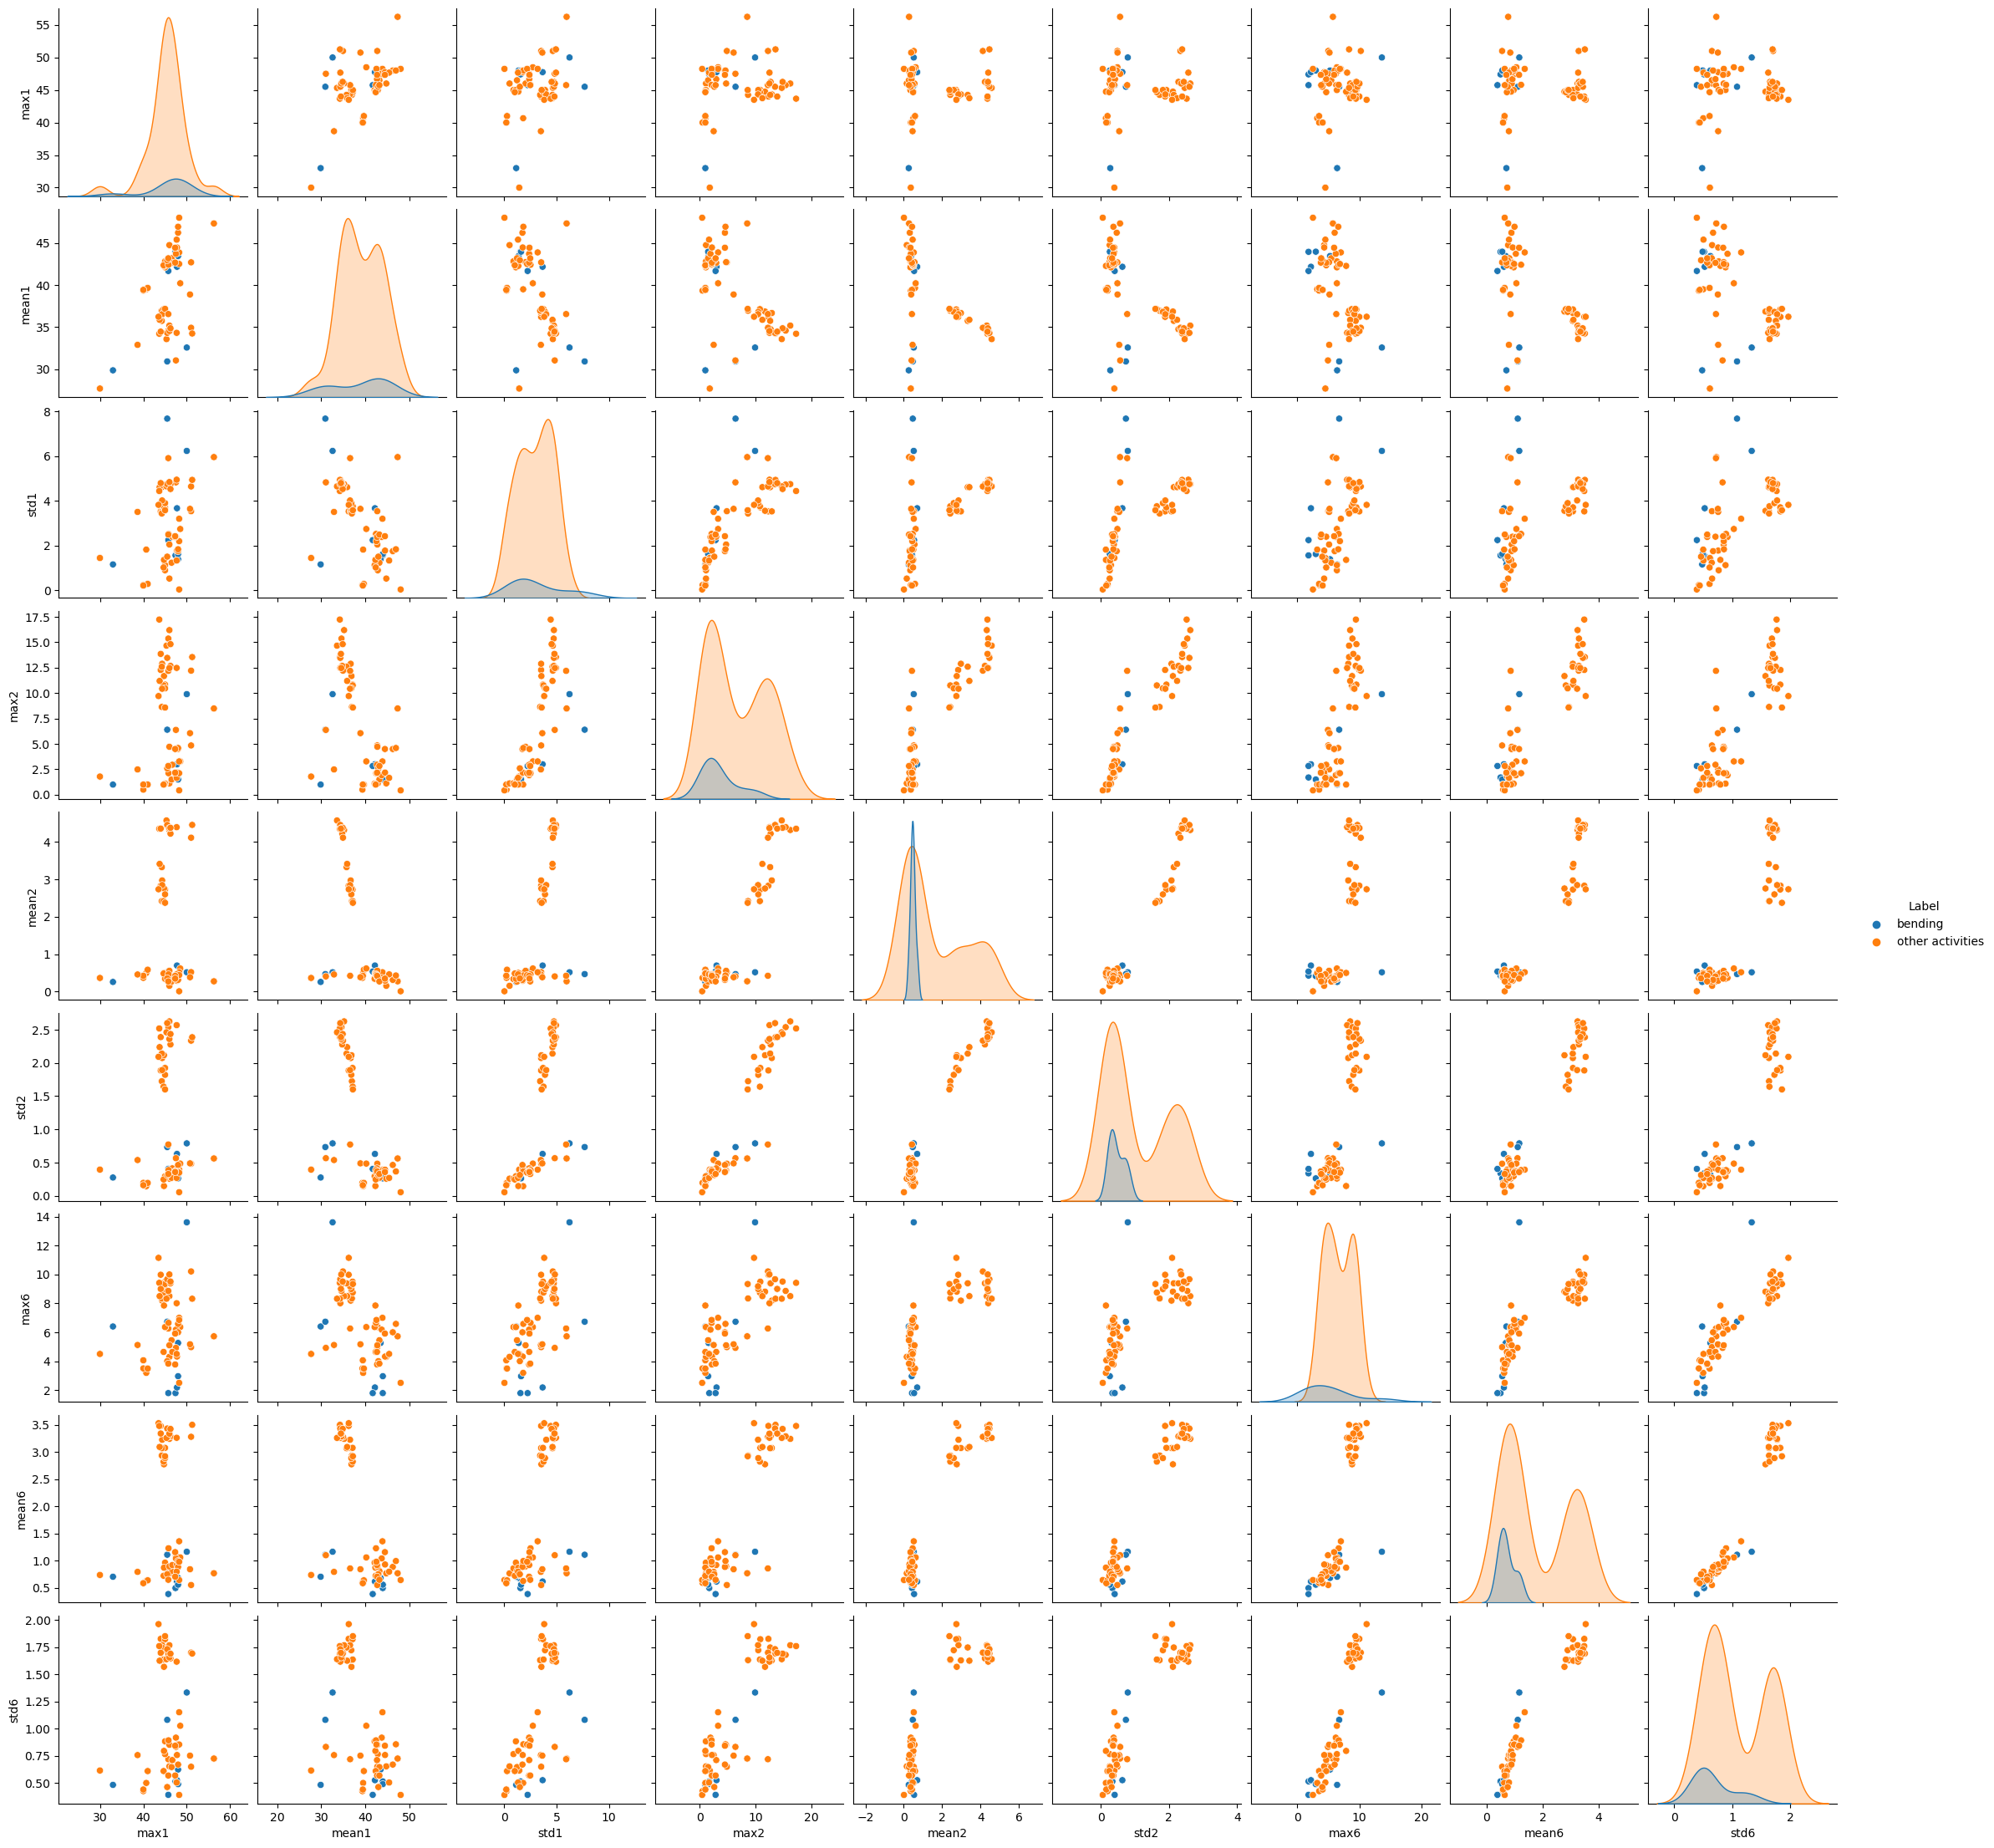

In [16]:
table_i = table_i.astype(float)
selected_cols = ['max1','mean1', 'std1', 'max2','mean2', 'std2','max6','mean6', 'std6']
selected_df0 = table_i[selected_cols]
selected_df0.loc[:8, 'Label'] = 'bending'
selected_df0.loc[9:, 'Label'] = 'other activities'
sns.pairplot(selected_df0, hue = 'Label')

#### ii. Splitted Plots

In [17]:
table = pd.DataFrame()

for item in train_paths:
    df = pd.read_csv(item, skiprows=4)
    df = df.drop(df.columns[0], axis=1) # drop the index col
    for column in df.columns:
        df[f'{column}_1'] = df[column].iloc[:len(df) // 2]
        df[f'{column}_2'] = df[column].iloc[len(df) // 2:]
    df = df.drop(columns=df.columns[:6])
    k = df.describe()
    df_temp = k.T
    df_temp = df_temp.rename(columns={'25%':'1st quart','50%':'median','75%':'3rd quart'})
    ordered_col = ['min','max','mean','median','std','1st quart','3rd quart']
    df_temp = df_temp[ordered_col]
    row_list = []
    for i in range(df_temp.shape[0]):
        row = ','.join(map(str, df_temp.iloc[i].values))
        row_list.append(',' + row)  # Add a comma before each row
    single_row = ' '.join(row_list)
    single_row = single_row[1:]
    df_now = pd.DataFrame([single_row.split(',')])
    table = pd.concat([table, df_now], axis=0)
    
ordered_col = ['min','max','mean','median','std','1st quart','3rd quart']
new_col = []
for i in range(1, 7):
    for item in ordered_col:
        new_col.append(f'{item}{i}_1')
    for item in ordered_col:    
        new_col.append(f'{item}{i}_2')
table.columns = new_col
table.index = range(1, len(train_paths)+1)
table.index.name = 'Instance'
table

min1_1 max1_1             mean1_1 median1_1              std1_1  \
Instance                                                                   
1          36.5   46.5   44.05716666666667      44.5  1.5569714639228338   
2         33.75  47.75           43.278875      45.0  3.4733548805972956   
3          33.0  45.75  41.621208333333335     42.33  3.1186442644947245   
4          39.0   48.0  44.117041666666665      45.0  1.3598363173456234   
5         36.67   45.0   43.48620833333334     43.71  1.2819758703453965   
...         ...    ...                 ...       ...                 ...   
65         19.5   45.0             33.3345      34.0   4.874433145887208   
66        20.33   44.5            34.03675    34.415   4.872880148477141   
67         19.5  43.33  34.033874999999995      35.0   4.758757219820808   
68        24.33   44.0  34.920791666666666     35.33   4.272282443681756   
69        19.25   44.0   34.91679166666667    35.375   4.634209175733125   

         1st quart1_1 3rd quart1_1 min1_2 max1_2             mean1_2  ...  \
Instance                                                              ...   
1               43.25        45.0    35.0   47.4   43.85183333333334  ...   
2                42.0       45.25    33.0   46.0  41.080749999999995  ...   
3             39.6525       44.25   39.25  43.67   41.73491666666667  ...   
4                43.5        45.0    37.0   46.5           42.792875  ...   
5               42.33        44.5   36.25   48.0  44.452041666666666  ...   
...               ...          ...    ...    ...                 ...  ...   
65            29.9375     36.8125   22.25  45.33            33.83925  ...   
66              30.75       37.75   19.75   45.5   34.60874999999999  ...   
67            30.9375        37.5   20.25   46.0   35.05858333333333  ...   
68              32.25     37.8125    23.5  46.25   34.82566666666666  ...   
69              31.75       38.25   20.75  43.33  34.029583333333335  ...   

                      std6_1        1st quart6_1 3rd quart6_1 min6_2 max6_2  \
Instance                                                                      
1         0.5266562438281538                 0.0         1.0     0.0    1.5   
2         0.5545418387969393                 0.0        1.22     0.0   2.18   
3         0.4111998889530915                 0.0        0.71     0.0    1.5   
4          0.718015507616045                0.43        1.12     0.0   4.06   
5         0.4868470683814705                 0.0        0.83     0.0   2.96   
...                      ...                 ...          ...    ...    ...   
65        1.6373100622326928                2.06       4.245    0.43   8.32   
66        1.7030983328366625                2.28        4.79     0.0   9.67   
67        1.6197672486129666  2.1500000000000004        4.15     0.0   8.64   
68         1.781927645819896                2.16       4.585     0.0   9.51   
69        1.7374195726044932  2.1500000000000004      4.5075    0.43   8.26   

                      mean6_2           median6_2               std6_2  \
Instance                                                                 
1         0.38833333333333336                 0.0   0.4785277864438846   
2          0.5860833333333333                0.47   0.4918725144103473   
3         0.34750000000000003                0.43   0.3631435277646042   
4                    0.543875                 0.5   0.4734450269193294   
5          0.5857499999999999                 0.5  0.48791789298291505   
...                       ...                 ...                  ...   
65         3.2902916666666666  3.1550000000000002   1.6460233296049924   
66          3.321416666666667  3.1550000000000002   1.7583785302909056   
67         3.4322083333333335               3.255   1.6910504392875993   
68         3.4186666666666667                3.35   1.5985356443994678   
69                      3.241                3.06   1.6575777053798666   

         1st quart6_2      

In [18]:
table = table.astype(float)
selected_elements = [ordered_col[1], ordered_col[2], ordered_col[4]]
selected_col = []
for i in [1,2,6]:
    for item in selected_elements:
        selected_col.append(f'{item}{i}_1')
        selected_col.append(f'{item}{i}_2')

selected_df = table[selected_col]
selected_df

max1_1  max1_2    mean1_1    mean1_2    std1_1    std1_2  max2_1  \
Instance                                                                     
1          46.50   47.40  44.057167  43.851833  1.556971  1.557168    1.50   
2          47.75   46.00  43.278875  41.080750  3.473355  3.537481    3.00   
3          45.75   43.67  41.621208  41.734917  3.118644  0.595920    2.83   
4          48.00   46.50  44.117042  42.792875  1.359836  1.058792    1.30   
5          45.00   48.00  43.486208  44.452042  1.281976  1.771251    1.30   
...          ...     ...        ...        ...       ...       ...     ...   
65         45.00   45.33  33.334500  33.839250  4.874433  4.411903   11.78   
66         44.50   45.50  34.036750  34.608750  4.872880  4.621400   13.47   
67         43.33   46.00  34.033875  35.058583  4.758757  4.880650   12.47   
68         44.00   46.25  34.920792  34.825667  4.272282  4.785599   14.82   
69         44.00   43.33  34.916792  34.029583  4.634209  4.923609   13.86   

          max2_2   mean2_1   mean2_2    std2_1    std2_2  max6_1  max6_2  \
Instance                                                                   
1           1.70  0.381042  0.471458  0.329540  0.342346    1.79    1.50   
2           2.86  0.673292  0.718792  0.634285  0.627915    1.53    2.18   
3           1.12  0.623083  0.448875  0.489595  0.273050    1.79    1.50   
4           1.58  0.250042  0.506125  0.314099  0.260761    5.26    4.06   
5           1.50  0.378667  0.447583  0.284434  0.235493    2.28    2.96   
...          ...       ...       ...       ...       ...     ...     ...   
65         14.67  4.408083  4.745042  2.196206  2.694219    8.29    8.32   
66         12.50  4.778292  4.134375  2.762730  2.387460    8.41    9.67   
67         12.28  4.574625  4.169292  2.391804  2.315929   10.00    8.64   
68         12.26  4.177958  4.583208  2.341763  2.514203    9.18    9.51   
69         12.97  4.262333  4.456292  2.396878  2.381634    9.00    8.26   

           mean6_1   mean6_2    std6_1    std6_2  
Instance                                          
1         0.598250  0.388333  0.526656  0.478528  
2         0.640958  0.586083  0.554542  0.491873  
3         0.419083  0.347500  0.411200  0.363144  
4         0.815417  0.543875  0.718016  0.473445  
5         0.524875  0.585750  0.486847  0.487918  
...            ...       ...       ...       ...  
65        3.229167  3.290292  1.637310  1.646023  
66        3.543708  3.321417  1.703098  1.758379  
67        3.244042  3.432208  1.619767  1.691050  
68        3.430625  3.418667  1.781928  1.598536  
69        3.439917  3.241000  1.737420  1.657578  

[69 rows x 18 columns]

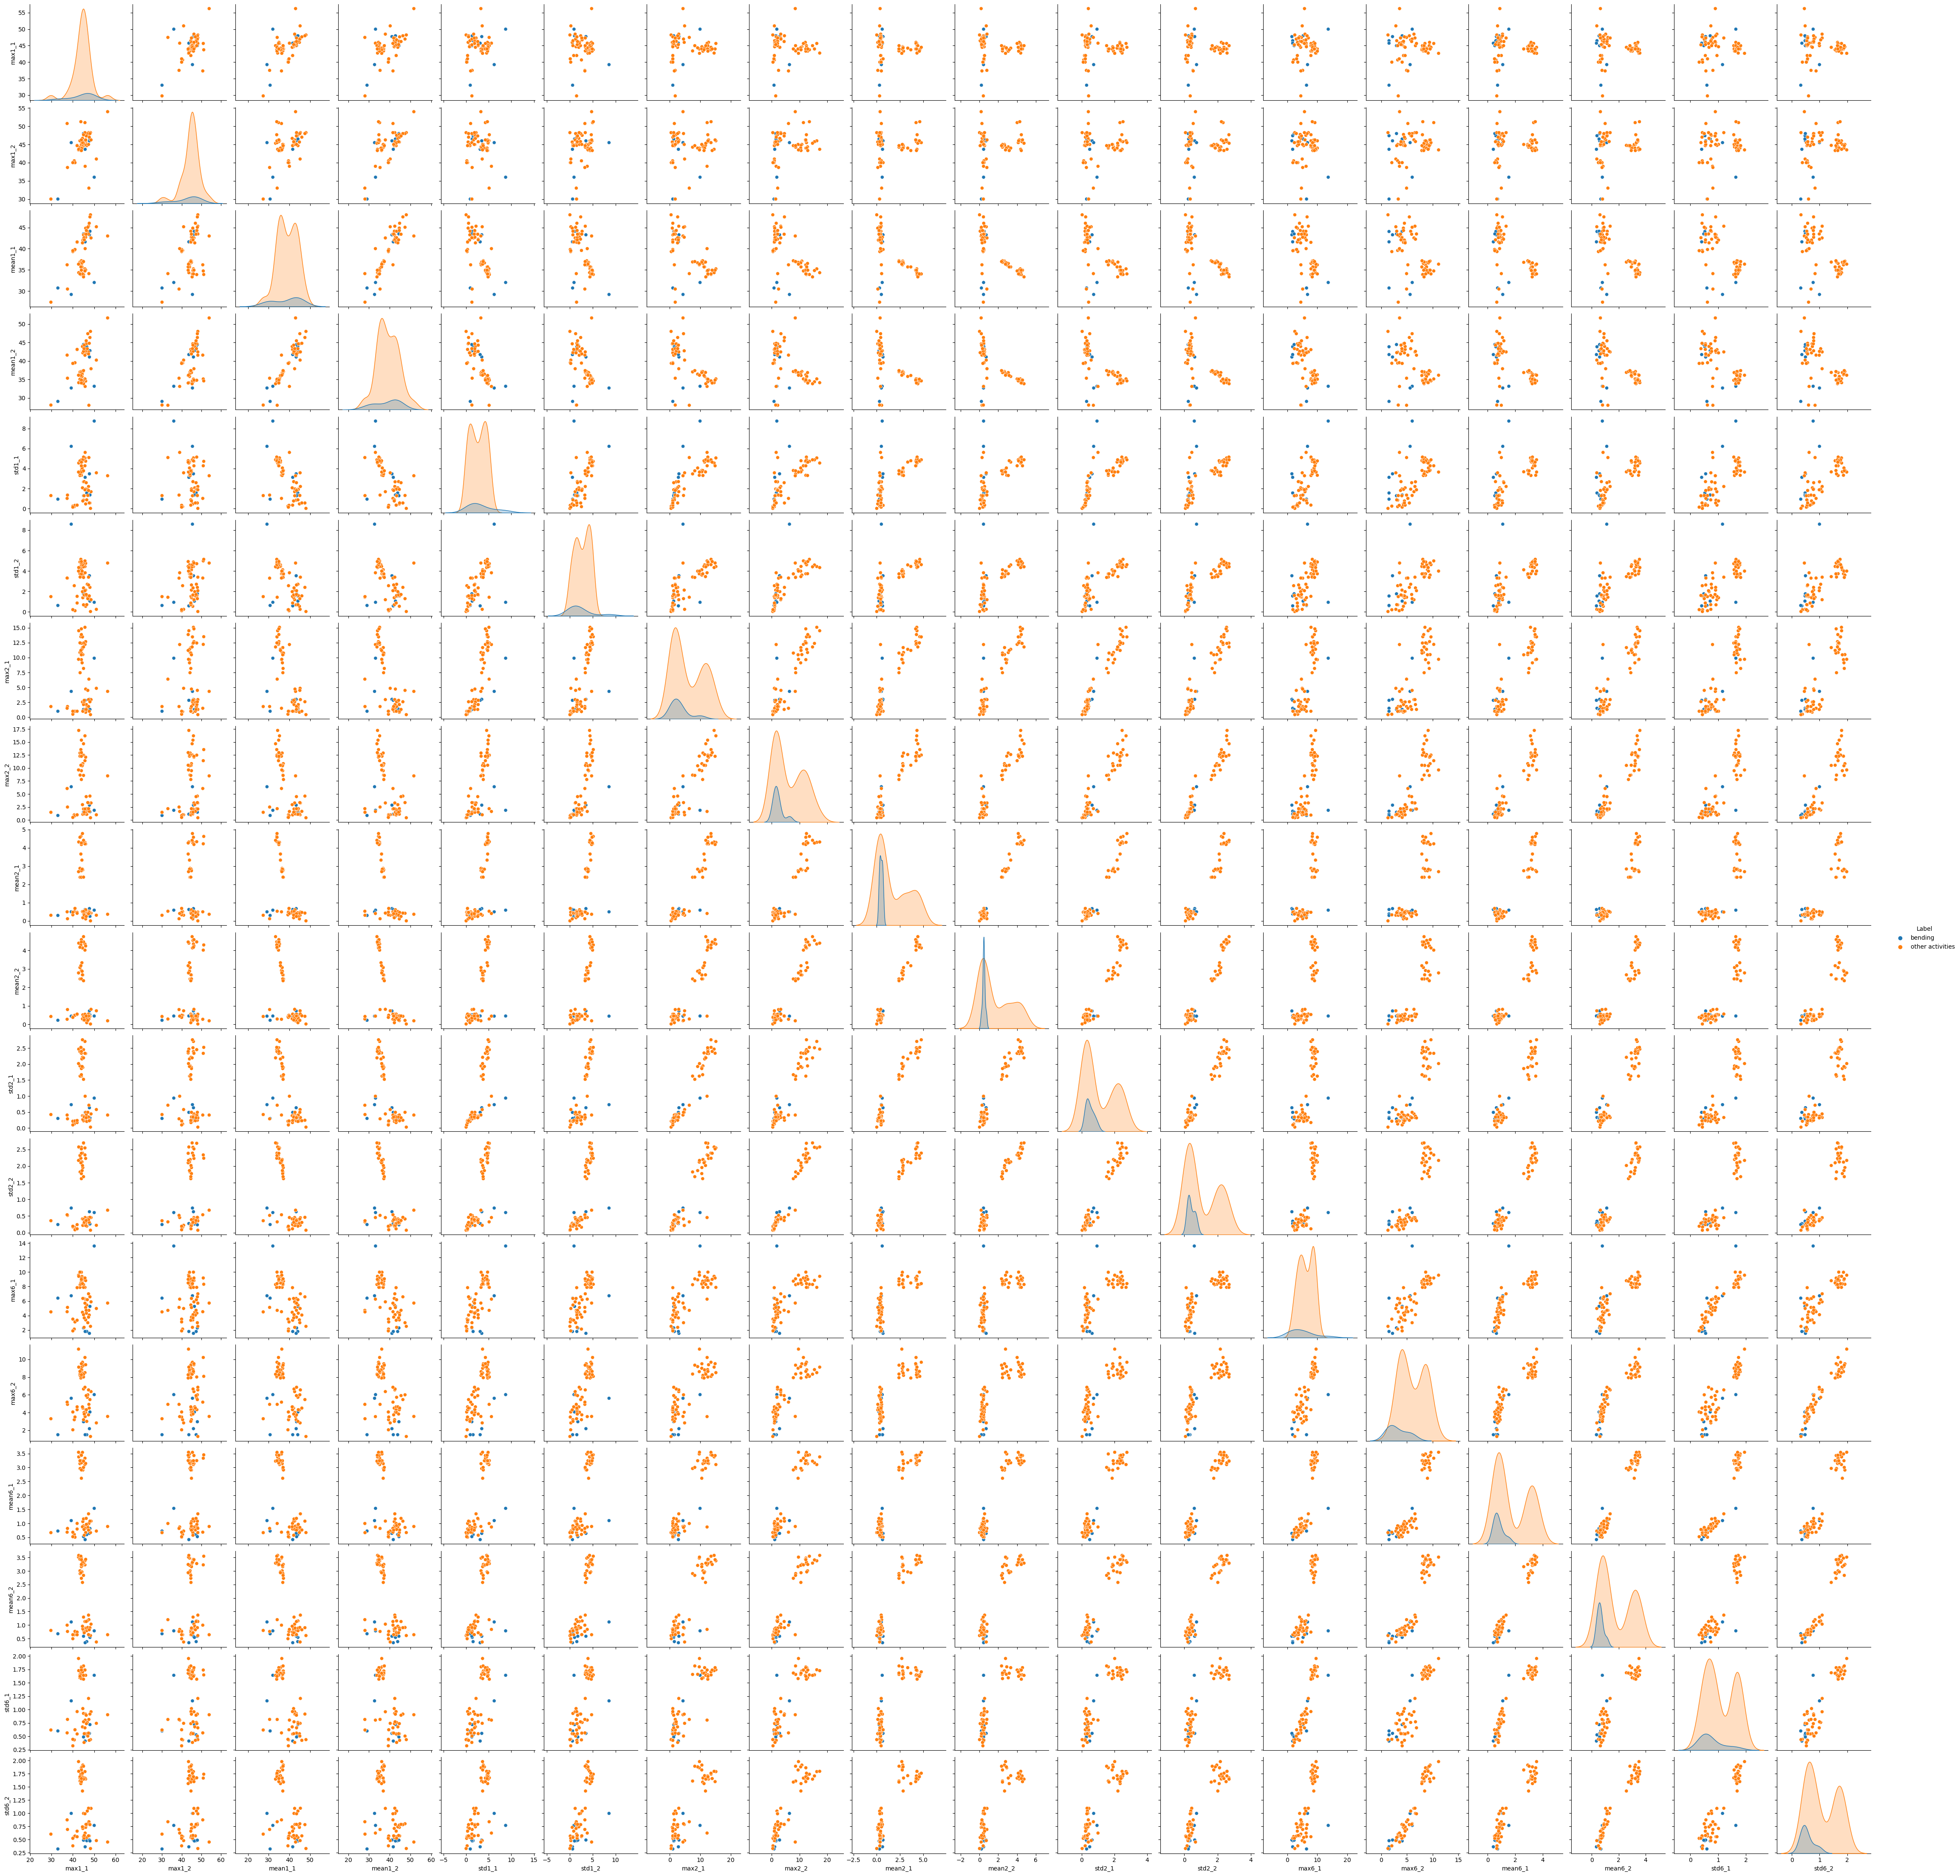

In [19]:
selected_df.loc[:8, 'Label'] = 'bending'
selected_df.loc[9:, 'Label'] = 'other activities'
sns.pairplot(selected_df, hue = 'Label')

In [20]:
selected_df0.corr()

max1     mean1      std1      max2     mean2      std2      max6  \
max1   1.000000  0.547813  0.395993  0.214561  0.045048  0.075793  0.115656   
mean1  0.547813  1.000000 -0.448470 -0.513924 -0.540346 -0.561892 -0.499250   
std1   0.395993 -0.448470  1.000000  0.798326  0.570734  0.662465  0.639797   
max2   0.214561 -0.513924  0.798326  1.000000  0.894625  0.940580  0.786969   
mean2  0.045048 -0.540346  0.570734  0.894625  1.000000  0.980024  0.725803   
std2   0.075793 -0.561892  0.662465  0.940580  0.980024  1.000000  0.780046   
max6   0.115656 -0.499250  0.639797  0.786969  0.725803  0.780046  1.000000   
mean6  0.050566 -0.525027  0.589442  0.895889  0.956782  0.974503  0.826360   
std6   0.101474 -0.518075  0.651967  0.883275  0.890589  0.933421  0.896760   

          mean6      std6  
max1   0.050566  0.101474  
mean1 -0.525027 -0.518075  
std1   0.589442  0.651967  
max2   0.895889  0.883275  
mean2  0.956782  0.890589  
std2   0.974503  0.933421  
max6   0.826360  0.896760  
mean6  1.000000  0.970599  
std6   0.970599  1.000000

In [21]:
selected_df.corr()

max1_1    max1_2   mean1_1   mean1_2    std1_1    std1_2    max2_1  \
max1_1   1.000000  0.655838  0.616000  0.586968  0.248296  0.086769  0.113371   
max1_2   0.655838  1.000000  0.505479  0.653971  0.049971  0.362325  0.113145   
mean1_1  0.616000  0.505479  1.000000  0.883912 -0.523529 -0.483677 -0.537308   
mean1_2  0.586968  0.653971  0.883912  1.000000 -0.510551 -0.327428 -0.543393   
std1_1   0.248296  0.049971 -0.523529 -0.510551  1.000000  0.700508  0.825567   
std1_2   0.086769  0.362325 -0.483677 -0.327428  0.700508  1.000000  0.720244   
max2_1   0.113371  0.113145 -0.537308 -0.543393  0.825567  0.720244  1.000000   
max2_2   0.090557  0.304514 -0.499878 -0.390431  0.675829  0.799620  0.893412   
mean2_1 -0.013815  0.181471 -0.534008 -0.507483  0.645788  0.685848  0.916306   
mean2_2 -0.022094  0.170406 -0.534585 -0.517946  0.634860  0.682624  0.909392   
std2_1   0.014960  0.140929 -0.566163 -0.550825  0.745816  0.725317  0.963125   
std2_2   0.016815  0.202826 -0.548828 -0.494356  0.691516  0.751186  0.928593   
max6_1   0.079717  0.055183 -0.521564 -0.490162  0.726381  0.612980  0.789046   
max6_2   0.040965  0.237380 -0.444184 -0.413459  0.614359  0.679657  0.813176   
mean6_1  0.026891  0.180144 -0.514105 -0.488092  0.673146  0.702847  0.913071   
mean6_2 -0.028471  0.176826 -0.524721 -0.504597  0.634672  0.704066  0.897746   
std6_1   0.089549  0.154173 -0.522408 -0.486763  0.745933  0.715250  0.889952   
std6_2  -0.009067  0.195917 -0.488924 -0.479626  0.635459  0.702734  0.855746   

           max2_2   mean2_1   mean2_2    std2_1    std2_2    max6_1    max6_2  \
max1_1   0.090557 -0.013815 -0.022094  0.014960  0.016815  0.079717  0.040965   
max1_2   0.304514  0.181471  0.170406  0.140929  0.202826  0.055183  0.237380   
mean1_1 -0.499878 -0.534008 -0.534585 -0.566163 -0.548828 -0.521564 -0.444184   
mean1_2 -0.390431 -0.507483 -0.517946 -0.550825 -0.494356 -0.490162 -0.413459   
std1_1   0.675829  0.645788  0.634860  0.745816  0.691516  0.726381  0.614359   
std1_2   0.799620  0.685848  0.682624  0.725317  0.751186  0.612980  0.679657   
max2_1   0.893412  0.916306  0.909392  0.963125  0.928593  0.789046  0.813176   
max2_2   1.000000  0.929164  0.929324  0.934462  0.966371  0.734616  0.840833   
mean2_1  0.929164  1.000000  0.990396  0.975592  0.972136  0.711621  0.833144   
mean2_2  0.929324  0.990396  1.000000  0.968091  0.975464  0.714211  0.836515   
std2_1   0.934462  0.975592  0.968091  1.000000  0.979714  0.766761  0.856433   
std2_2   0.966371  0.972136  0.975464  0.979714  1.000000  0.763391  0.876615   
max6_1   0.734616  0.711621  0.714211  0.766761  0.763391  1.000000  0.798789   
max6_2   0.840833  0.833144  0.836515  0.856433  0.876615  0.798789  1.000000   
mean6_1  0.926413  0.948487  0.948541  0.962843  0.974692  0.826095  0.915224   
mean6_2  0.929772  0.953809  0.952164  0.956804  0.972374  0.778515  0.924983   
std6_1   0.876978  0.861658  0.864515  0.905909  0.910896  0.923040  0.899153   
std6_2   0.888312  0.888716  0.890621  0.911378  0.928378  0.787272  0.961304   

          mean6_1   mean6_2    std6_1    std6_2  
max1_1   0.026891 -0.028471  0.089549 -0.009067  
max1_2   0.180144  0.176826  0.154173  0.195917  
mean1_1 -0.514105 -0.524721 -0.522408 -0.488924  
mean1_2 -0.488092 -0.504597 -0.486763 -0.479626  
std1_1   0.673146  0.634672  0.745933  0.635459  
std1_2   0.702847  0.704066  0.715250  0.702734  
max2_1   0.913071  0.897746  0.889952  0.855746  
max2_2   0.926413  0.929772  0.876978  0.888312  
mean2_1  0.948487  0.953809  0.861658  0.888716  
mean2_2  0.948541  0.952164  0.864515  0.890621  
std2_1   0.962843  0.956804  0.905909  0.911378  
std2_2   0.974692  0.972374  0.910896  0.928378  
max6_1   0.826095  0.778515  0.923040  0.787272  
max6_2   0.915224  0.924983  0.899153  0.961304  
mean6_1  1.000000  0.984462  0.954616  0.957555  
mean6_2  0.984462  1.000000  0.922888  0.974099  
std6_1   0.954616  0.922888  1.000000  0.925741  
std6_2   0.957555  0.974099  0.

We can see the linear relationships between each two of these numerical variables except the diagonal line by looking at the correlation matrix.After spliting, the correlation changes and become more detailed. For example, in (i), the correlation between max1 and std1 is 0.396; after spliting, we can look at max1_1, max1_2 & std1_1, std1_2. We noticed that max1_2 and std1_2 has a higher correlation than in (i), which is 0.362, the other three terms is lower.
We can keep splitting and focus on the data that has more correlation.

#### iii. Time Series Segments

In [22]:
def my_split(df, L):
    df = df.drop(df.columns[0], axis=1)
    length = len(df) // L
    time_series_segments = []

    for i in range(L):
        start_idx = i * length
        end_idx = (i + 1) * length
        segment = df[start_idx:end_idx]
        time_series_segments.append(segment)

    segments_df = pd.concat(time_series_segments, axis=1)
    return segments_df

In [23]:
def get_df_for_each_instance(L):
    table = pd.DataFrame()
    ordered_col = ['max','mean','std']
    
    
    for item in train_paths:
        selected_col = []
        df = pd.read_csv(item, skiprows=4)
        df = my_split(df, L)
        k = df.describe().drop('count')
        
        df_temp = k.drop(['min', '25%', '50%', '75%'])
        df_temp = df_temp.T

        df_temp = df_temp[ordered_col]
        row_list = []
        for i in range(df_temp.shape[0]):
            row = ','.join(map(str, df_temp.iloc[i].values))
            row_list.append(',' + row)  # Add a comma before each row
        single_row = ' '.join(row_list)
        single_row = single_row[1:]
        df_now = pd.DataFrame([single_row.split(',')])
        table = pd.concat([table, df_now], axis=0)
    
        
                      
    table = table.astype(float)
    table.index = range(1,len(train_paths)+1)
    table.index.name = 'Instance'
    table = table.astype(float)
    return table


In [24]:
# using your pruned set of features
for L in range(1,21): 
    DF = get_df_for_each_instance(L)
    DF.reset_index(drop=True, inplace=True)
    data = [1]* 9 + [0]*(69-9)
    y = pd.DataFrame(data)
    result = pd.concat([DF,y], axis =1)
    X = result.iloc[:, :-1]
    y = result.iloc[:, -1]

    logreg = LogisticRegression(max_iter = 1000, penalty='none')

    # Use SelectKBest with chi2 test to get p-values
    
    k = 10 # number of top features to select 

    # Perform chi-square feature selection
    selector = SelectKBest(chi2, k=k)
    X_new = selector.fit_transform(X, y)

    selected_indices = np.where(selector.get_support())[0]
    selected_features = result.columns[selected_indices]
    p_values = selector.pvalues_[selected_indices]

    selected_pvalues_df = pd.DataFrame({'Feature': selected_features, 'P-Value': p_values})
    print(f'For L = {L}')
    print('=============')
    print(selected_pvalues_df)

For L = 1
   Feature       P-Value
0        3  1.209810e-03
1        4  5.736801e-03
2        5  9.163772e-02
3        6  2.203153e-03
4        7  6.443739e-02
5       10  5.135780e-02
6       12  3.221813e-12
7       13  1.940859e-11
8       15  7.300402e-02
9       16  2.569169e-02
For L = 2
   Feature       P-Value
0        3  3.045483e-03
1        4  6.345879e-03
2        6  2.047800e-03
3       12  3.824465e-13
4       13  3.559162e-14
5       21  4.262945e-06
6       22  5.180492e-03
7       30  5.523690e-06
8       31  4.945937e-09
9       33  1.297306e-03
For L = 3
   Feature       P-Value
0        3  6.993488e-04
1        6  1.818562e-03
2       12  1.825393e-14
3       13  6.262402e-17
4       30  4.391141e-06
5       31  6.228236e-09
6       39  9.582688e-06
7       48  8.825701e-06
8       49  2.439482e-09
9       51  8.283802e-04
For L = 4
   Feature       P-Value
0       12  1.143036e-14
1       13  1.086524e-17
2       30  7.326985e-09
3       31  4.344599e-11
4       39

For p values, I only print out the top 10 p-values for each L.

In [25]:
cv_scores_list = []
pairs_list = []
best_cv = float('-inf')

for L in range(1,21):
    selected_col=[]
    DF = get_df_for_each_instance(L)
    DF.reset_index(drop=True, inplace=True)
    data = [1]* 9 + [0]*(69-9)
    y = pd.DataFrame(data)
    result = pd.concat([DF,y], axis =1)
    ordered_col = ['max','mean','std']    
    # reset the index to be readable
    for i in range(1,7):
        for item in ordered_col:
            for v in range(1,L+1):
                selected_col.append(f'{item}{i}_{v}')
    
    X_train = result.iloc[:, :-1]
    y_train = result.iloc[:, -1]
    
    model = LogisticRegression(penalty='none')
    rfecv = RFECV(model, step = 1, cv = StratifiedKFold(5), scoring = 'accuracy')
    rfecv = rfecv.fit(X_train, y_train)
    
    cv_score = max(rfecv.cv_results_['mean_test_score'])
    cv_scores_list.append(cv_score)
    print(f'cross validation score for L = {L} is {cv_score}')
    
    if cv_score > best_cv:
        best_cv = cv_score
        selected_feature = [col for col, selected in zip(X_train.columns, rfecv.support_) if selected]
        res = [selected_col[i] for i in selected_feature]
   
    p = rfecv.n_features_
    pairs_list.append((L, p))
    
best_pair = pairs_list[cv_scores_list.index(max(cv_scores_list))]

print(f'best (l,p) pair is {best_pair}')   
print(f'The selected features for this pair is {res}')

cross validation score for L = 1 is 0.9857142857142858
cross validation score for L = 2 is 1.0
cross validation score for L = 3 is 0.9857142857142858
cross validation score for L = 4 is 1.0
cross validation score for L = 5 is 0.9714285714285715
cross validation score for L = 6 is 0.9714285714285715
cross validation score for L = 7 is 0.9857142857142858
cross validation score for L = 8 is 0.9857142857142858
cross validation score for L = 9 is 0.9714285714285715
cross validation score for L = 10 is 0.9714285714285715
cross validation score for L = 11 is 0.9857142857142858
cross validation score for L = 12 is 0.9857142857142858
cross validation score for L = 13 is 0.9714285714285715
cross validation score for L = 14 is 0.9857142857142858
cross validation score for L = 15 is 0.9857142857142858
cross validation score for L = 16 is 1.0
cross validation score for L = 17 is 0.9857142857142858
cross validation score for L = 18 is 0.9857142857142858
cross validation score for L = 19 is 0.9714285

The wrong way to perform cross-validation would be to do feature selection and hyperparameter tuning before splitting the data into folds, as it can lead to data leakage and overfitting. (only do cross validation when apply a classifier like logistic regression).

The correct way is to apply cross validation both on 'when trying to find the subset of all the time-domain features which have the relatively largest correlation with the activity labels', and then also on 'when applu a classifier like logistic regression using the subset just mentioned'. 

#### iv. Confusion Matrix

In [26]:
selected_col=[]
DF = get_df_for_each_instance(best_pair[0])
DF.reset_index(drop=True, inplace=True)
data = [1]* 9 + [0]*(69-9)
y = pd.DataFrame(data)
result = pd.concat([DF,y], axis =1)  
# reset the index to be readable
for i in range(1,7):
    for item in ordered_col:
        for v in range(1,best_pair[0]+1):
            selected_col.append(f'{item}{i}_{v}')
          
X_train = result.iloc[:, :-1]
X_train.columns = selected_col 
y_train = result.iloc[:, -1]
X_train_refit = X_train[res]
X_train_with_constant = sm.add_constant(X_train_refit)
log_reg = LogisticRegression()
log_reg = log_reg.fit(X_train_with_constant, y_train)

In [27]:
# confusion matrix for train
data = [1]* 9 + [0]*(69-9)
y_train = pd.DataFrame(data)
y_pred = log_reg.predict(X_train_with_constant)
confusion = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(confusion)

# Retrieve coefficients 
model = sm.Logit(y_train, X_train_with_constant)
result = model.fit()
coef_df = pd.DataFrame({'Coef': result.params, 'P-Value': result.pvalues})

print("Logistic Regression Coefficients and P-Values:")
print(coef_df)

Confusion Matrix:
[[60  0]
 [ 0  9]]
         Current function value: 0.000003
         Iterations: 35
Logistic Regression Coefficients and P-Values:
              Coef   P-Value
const  -123.753490  0.999999
max1_1  -13.586176  0.999999
max3_1   15.318962  0.999999
max3_2   14.886787  0.999999
max6_2   -1.963738  1.000000


The AUC of this model is 1.0
ROC is below


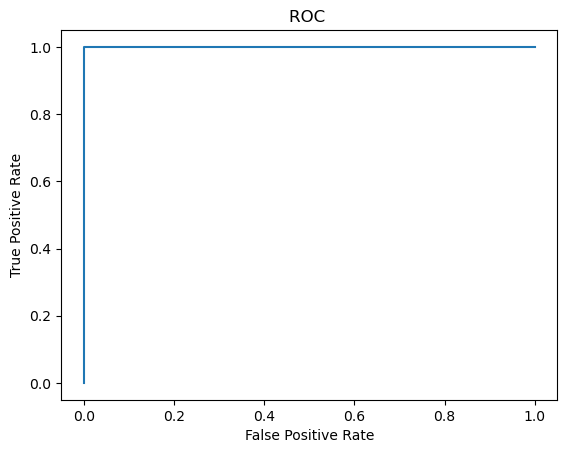

In [28]:
# ROC and AUC

predicted_prob = log_reg.predict_proba(X_train_with_constant)[:, 1] # predict the probabilities of the different classes
fpr, tpr, threshold = roc_curve(y_train, predicted_prob)

plt.plot(fpr,tpr)
plt.title('ROC ')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


auc = roc_auc_score(y_train, predicted_prob)
print(f'The AUC of this model is {auc}')
print('ROC is below')

#### v. Test Classifier

In [29]:
def get_df_for_each_instance_test(L):
    table = pd.DataFrame()
    for item in test_paths:
        df = pd.read_csv(item, skiprows=4)
        df = my_split(df, L)
        k = df.describe().drop('count')
        
        df_temp = k.drop(['min', '25%', '50%', '75%'])
        df_temp = df_temp.T

        ordered_col = ['max','mean','std']
        df_temp = df_temp[ordered_col]
        row_list = []
        for i in range(df_temp.shape[0]):
            row = ','.join(map(str, df_temp.iloc[i].values))
            row_list.append(',' + row)  # Add a comma before each row
        single_row = ' '.join(row_list)
        single_row = single_row[1:]
        df_now = pd.DataFrame([single_row.split(',')])
        table = pd.concat([table, df_now], axis=0)
    table = table.astype(float)
    table.index.name = 'Instance'
    table = table.astype(float)
    return table

In [30]:
selected_col=[]
DF = get_df_for_each_instance(best_pair[0])
DF.reset_index(drop=True, inplace=True)
data = [1]* 9 + [0]*(69-9)
y = pd.DataFrame(data)
result = pd.concat([DF,y], axis =1)
ordered_col = ['max','mean','std']
    
# reset the index to be readable
for i in range(1,7):
    for item in ordered_col:
        for v in range(1,best_pair[0]+1):
            selected_col.append(f'{item}{i}_{v}')
    
X_train = result.iloc[:, :-1]
y_train = result.iloc[:, -1]
X_train.columns = selected_col

X_train_refit = X_train[res]
X_train_with_constant = sm.add_constant(X_train_refit)

lg = LogisticRegression(penalty='none')
lg = lg.fit(X_train_with_constant, y_train)

In [31]:
#use test set to refit
selected_col=[]
DF = get_df_for_each_instance_test(best_pair[0])
DF.reset_index(drop=True, inplace=True)
data = [1]* 4 + [0]*(19-4)
y = pd.DataFrame(data)
result = pd.concat([DF,y], axis =1)
ordered_col = ['max','mean','std']
    
# reset the index to be readable
for i in range(1,7):
    for item in ordered_col:
        for v in range(1,best_pair[0]+1):
            selected_col.append(f'{item}{i}_{v}')
    
X_test = result.iloc[:, :-1]
y_test= result.iloc[:, -1]    
X_test.columns = selected_col

X_test_refit = X_test[res]
X_test_with_constant = sm.add_constant(X_test_refit)


y_pred = lg.predict(X_test_with_constant)

accuracy = accuracy_score(y_test, y_pred)
print('Confusion matrix on test set is')
print(confusion_matrix(y_test, y_pred))
print(f'The accuracy_score on test set is {accuracy}')

Confusion matrix on test set is
[[15  0]
 [ 1  3]]
The accuracy_score on test set is 0.9473684210526315


The test set has higher accuracy than the cross-validation accuracy obtained previously.

#### vi. Separation

Yes, my classes seem to be well-separated. There exists instability in my classes. My logistic regression algorithms cannot converge to a solution at the beginning. So, I tried to modify the Max-Iter parameter and try other methods.

#### vii. Imbalance

Yes, the classes are imbalanced. We have 9 bending and 60 not bending.

In [32]:
#case-control sampling
cv_scores_list = []
best_cv = float('-inf')
pairs_list = []

for L in range(1,21):
    selected_col=[]
    DF = get_df_for_each_instance(L)
    DF.reset_index(drop=True, inplace=True)
    data = [1]* 9 + [0]*(69-9)
    y = pd.DataFrame(data)
    result = pd.concat([DF,y], axis =1)
    ordered_col = ['max','mean','std']
    
    # reset the index to be readable
    for i in range(1,7):
        for item in ordered_col:
            for v in range(1,L+1):
                selected_col.append(f'{item}{i}_{v}')
    
    X_train = result.iloc[:, :-1]
    y_train = result.iloc[:, -1]
    
    oversample = SMOTE(random_state = 66)
    X_train, y_train = oversample.fit_resample(X_train, y_train)
    
    model = LogisticRegression(penalty='none')
    rfecv = RFECV(model, step = 1, cv = StratifiedKFold(5), scoring = 'accuracy')
    rfecv = rfecv.fit(X_train, y_train)
    
    cv_score = max(rfecv.cv_results_['mean_test_score'])
    cv_scores_list.append(cv_score)
    if cv_score > best_cv:
        best_cv = cv_score
        
        selected_feature = [col for col, selected in zip(X_train.columns, rfecv.support_) if selected]
        res = [selected_col[i] for i in selected_feature]
    p = rfecv.n_features_
    pairs_list.append((L, p))

#
best_pair = pairs_list[cv_scores_list.index(max(cv_scores_list))]

print(f'best (l,p) pair is {best_pair}')
print(f'The selected features for this pair is {res}')    

best (l,p) pair is (4, 3)
The selected features for this pair is ['max2_2', 'std3_2', 'max4_2']


In [33]:
selected_col=[]
DF = get_df_for_each_instance(best_pair[0])
DF.reset_index(drop=True, inplace=True)
data = [1]* 9 + [0]*(69-9)
y = pd.DataFrame(data)
result = pd.concat([DF,y], axis =1)
ordered_col = ['max','mean','std']
    
# reset the index to be readable
for i in range(1,7):
    for item in ordered_col:
        for v in range(1,best_pair[0]+1):
            selected_col.append(f'{item}{i}_{v}')
    
X_train = result.iloc[:, :-1]
y_train = result.iloc[:, -1]
    
oversample = SMOTE(random_state = 66)
X_train, y_train = oversample.fit_resample(X_train, y_train)
    
X_train.columns = selected_col

X_train_refit = X_train[res]
X_train_with_constant = sm.add_constant(X_train_refit)

LG = LogisticRegression(penalty='none')
LG = LG.fit(X_train_with_constant, y_train)

y_pred = LG.predict(X_train_with_constant)
print('Confusion matrix is')
print(confusion_matrix(y_train, y_pred))

Confusion matrix is
[[60  0]
 [ 0 60]]


The AUC of this model is 1.0
ROC is below


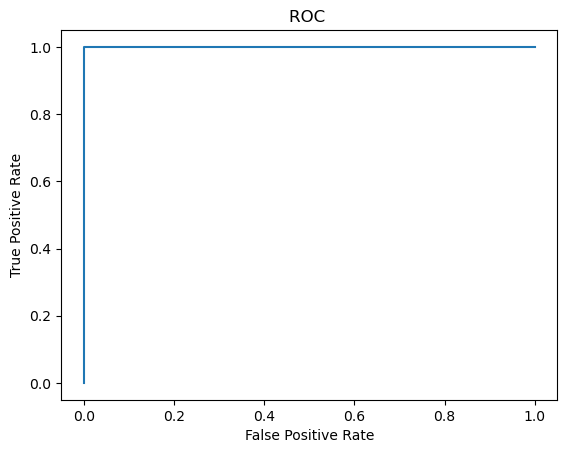

In [34]:
# ROC and AUC

predicted_prob = LG.predict_proba(X_train_with_constant)[:, 1] # predict the probabilities of the different classes

fpr, tpr, threshold = roc_curve(y_train, predicted_prob)


plt.plot(fpr,tpr)
plt.title('ROC ')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


auc = roc_auc_score(y_train, predicted_prob)
print(f'The AUC of this model is {auc}')
print('ROC is below')

In [35]:
X_train_with_constant.reset_index(drop=True, inplace=True)
model = sm.Logit(y_train, X_train_with_constant)
res = model.fit(method = 'lbfgs')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                          Logit   Df Residuals:                      116
Method:                           MLE   Df Model:                            3
Date:                Tue, 17 Oct 2023   Pseudo R-squ.:                   1.000
Time:                        05:42:20   Log-Likelihood:            -0.00011827
converged:                       True   LL-Null:                       -83.178
Covariance Type:            nonrobust   LLR p-value:                 7.789e-36
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3266   1.53e+04  -2.13e-05      1.000      -3e+04       3e+04
max2_2        17.1358    668.858      0.026      0.980   -1293.802    1328.074
std3_2       -11.5380    653.249     -0.018      0.986   -1291.882    1268.806
max4_2        -8.2252     80.794     -0.102      0.919    -166.579     150.129
==============================================================================

Complete Separation: The results show that there iscomplete separation or perfect prediction.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified.
"""

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [36]:
cv_scores_list = []
pairs_list = []
best_cv = float('-inf')

for L in range(1,21):
    selected_col=[]
    DF = get_df_for_each_instance(L)
    DF.reset_index(drop=True, inplace=True)
    data = [1]* 9 + [0]*(69-9)
    y = pd.DataFrame(data)
    result = pd.concat([DF,y], axis =1)
    ordered_col = ['max','mean','std']
    
    # reset the index to be readable
    for i in range(1,7):
        for item in ordered_col:
            for v in range(1,L+1):
                selected_col.append(f'{item}{i}_{v}')
    
    X_train = result.iloc[:, :-1]
    y_train = result.iloc[:, -1]
    
    model = LogisticRegressionCV(penalty = 'l1', cv = StratifiedKFold(5), scoring = 'accuracy', solver = 'liblinear', refit = True, random_state = 66)
    rfecv = RFECV(model, step = 1, cv = StratifiedKFold(5), scoring = 'accuracy')
    rfecv = rfecv.fit(X_train, y_train)
    
    cv_score = max(rfecv.cv_results_['mean_test_score'])
    cv_scores_list.append(cv_score)
    
    if cv_score > best_cv:
        best_cv = cv_score
        selected_feature = [col for col, selected in zip(X_train.columns, rfecv.support_) if selected]
        res = [selected_col[i] for i in selected_feature]
   
    p = rfecv.n_features_
    pairs_list.append((L, p))

#
best_pair = pairs_list[cv_scores_list.index(max(cv_scores_list))]

print(f'best (l,p) pair is {best_pair}')   
print(f'The selected features for this pair is {res}')

best (l,p) pair is (3, 6)
The selected features for this pair is ['max1_1', 'mean1_1', 'std1_2', 'mean2_1', 'mean2_2', 'max3_1']


#### ii. Comparison

In [37]:
#refit by features above to train
selected_col=[]
DF = get_df_for_each_instance(best_pair[0])
DF.reset_index(drop=True, inplace=True)
data = [1]* 9 + [0]*(69-9)
y = pd.DataFrame(data)
result = pd.concat([DF,y], axis =1)  
# reset the index to be readable
for i in range(1,7):
    for item in ordered_col:
        for v in range(1,best_pair[0]+1):
            selected_col.append(f'{item}{i}_{v}')
          
X_train = result.iloc[:, :-1]
X_train.columns = selected_col 
y_train = result.iloc[:, -1]
X_train_refit = X_train[res]
X_train_with_constant = sm.add_constant(X_train_refit)

LG = LogisticRegressionCV(penalty = 'l1', cv = StratifiedKFold(5), scoring = 'accuracy', solver = 'liblinear', refit = True, random_state = 66)
LG = log_reg.fit(X_train_with_constant, y_train)


In [38]:

selected_col=[]
DF = get_df_for_each_instance_test(best_pair[0])
DF.reset_index(drop=True, inplace=True)
data = [1]* 4 + [0]*(19-4)
y = pd.DataFrame(data)
result = pd.concat([DF,y], axis =1)
ordered_col = ['max','mean','std']
    
# reset the index to be readable
for i in range(1,7):
    for item in ordered_col:
        for v in range(1,best_pair[0]+1):
            selected_col.append(f'{item}{i}_{v}')
    
X_test = result.iloc[:, :-1]
y_test= result.iloc[:, -1]    
X_test.columns = selected_col

X_test_refit = X_test[res]
X_test_with_constant = sm.add_constant(X_test_refit)
y_pred = LG.predict(X_test_with_constant)

accuracy = accuracy_score(y_test, y_pred)
print('Confusion matrix of L1-penalized on test set is')
print(confusion_matrix(y_test, y_pred))
print(f'The accuracy_score of L1-penalized on test set is {accuracy}')

Confusion matrix of L1-penalized on test set is
[[15  0]
 [ 1  3]]
The accuracy_score of L1-penalized on test set is 0.9473684210526315


The AUC of this model is 1.0
ROC is below


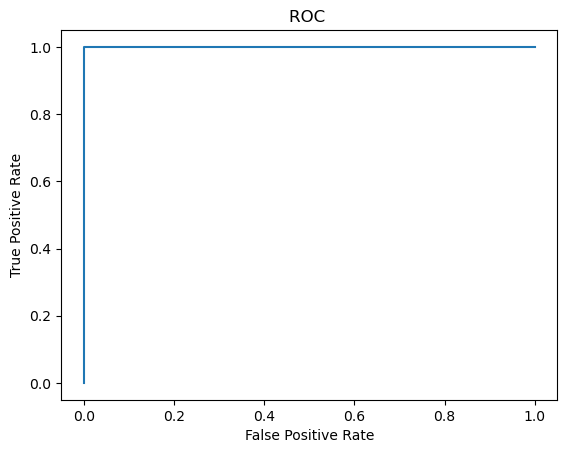

In [39]:
# ROC and AUC
predicted_prob = LG.predict_proba(X_train_with_constant)[:, 1] # predict the probabilities of the different classes
fpr, tpr, threshold = roc_curve(y_train, predicted_prob)

plt.plot(fpr,tpr)
plt.title('ROC ')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

auc = roc_auc_score(y_train, predicted_prob)
print(f'The AUC of this model is {auc}')
print('ROC is below')

L1-penalized performs better, because it has a higher accuracy score on test set, which is 1.0; while the other one has 0.947 accuracy.
The variable selection is easier to implement. (L1 does not provide p values).
The run time of L1-penalized is much longer than the other one.

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [40]:
activity_col_list = []
for item in train_paths:
    activity = item.split('/')[3][:7]
    activity_col_list.append(activity)
    
yyy_train= pd.DataFrame(activity_col_list, columns = ['Activity'])

In [41]:
best_cv_score = -math.inf

for L in range(1,21):
    selected_col=[]
    DF = get_df_for_each_instance(L)
    DF.reset_index(drop=True, inplace=True)

    result = pd.concat([DF,yyy_train], axis =1)
    ordered_col = ['max','mean','std']
    
    # reset the index to be readable
    for i in range(1,7):
        for item in ordered_col:
            for v in range(1,L+1):
                selected_col.append(f'{item}{i}_{v}')
    
    X_train = result.iloc[:, :-1]
    y_train = result.iloc[:, -1]
    
    log_reg = LogisticRegressionCV(penalty = 'l1', cv = StratifiedKFold(5), scoring = 'accuracy', solver = 'saga', refit = True, multi_class = 'multinomial', random_state = 66)
    log_reg = log_reg.fit(X_train, y_train)
    
    cv_score = log_reg.score(X_train, y_train)
    print(f'CV_score for L = {L} is {cv_score}')

    if cv_score > best_cv_score:
        best_cv_score = cv_score 
        best_l = L
        
print(f'The best_L for this  L1-penalized multinomial regression model is {best_l}')

CV_score for L = 1 is 0.9710144927536232
CV_score for L = 2 is 1.0
CV_score for L = 3 is 1.0
CV_score for L = 4 is 1.0
CV_score for L = 5 is 1.0
CV_score for L = 6 is 1.0
CV_score for L = 7 is 1.0
CV_score for L = 8 is 1.0
CV_score for L = 9 is 1.0
CV_score for L = 10 is 1.0
CV_score for L = 11 is 1.0
CV_score for L = 12 is 1.0
CV_score for L = 13 is 1.0
CV_score for L = 14 is 1.0
CV_score for L = 15 is 1.0
CV_score for L = 16 is 1.0
CV_score for L = 17 is 1.0
CV_score for L = 18 is 1.0
CV_score for L = 19 is 1.0
CV_score for L = 20 is 1.0
The best_L for this  L1-penalized multinomial regression model is 2


In [42]:
selected_col=[]
DF = get_df_for_each_instance(best_l)
DF.reset_index(drop=True, inplace=True)

result = pd.concat([DF,yyy_train], axis =1)
X_train = result.iloc[:, :-1]
y_train = result.iloc[:, -1]
log_reg = LogisticRegressionCV(penalty = 'l1', cv = StratifiedKFold(5), scoring = 'accuracy', solver = 'saga', refit = True, multi_class = 'multinomial', random_state = 66)
log_reg = log_reg.fit(X_train, y_train)

In [46]:
activity_col_list = []
for item in test_paths:
    activity = item.split('/')[3][:7]
    activity_col_list.append(activity)
    
yyy_test= pd.DataFrame(activity_col_list, columns = ['Activity'])

selected_col=[]
DF = get_df_for_each_instance_test(best_l)
DF.reset_index(drop=True, inplace=True)

result = pd.concat([DF,yyy_test], axis =1)
ordered_col = ['max','mean','std']
    
# reset the index to be readable
for i in range(1,7):
    for item in ordered_col:
        for v in range(1,best_l+1):
            selected_col.append(f'{item}{i}_{v}')
    
X_test = result.iloc[:, :-1]
y_test = result.iloc[:, -1]

y_pred_train = log_reg.predict(X_train)
print('confusion matrix for train data:')
print(confusion_matrix(yyy_train, y_pred_train))

y_pred_test = log_reg.predict(X_test)
print('confusion matrix for test data:')
print(confusion_matrix(yyy_test, y_pred_test))



accuracy = accuracy_score(yyy_test, y_pred_test)
print(f'Accuracy for test: {accuracy}')
print(f'so that the test error is {1-accuracy}.')
report = classification_report(y_test, y_pred_test)
print(report) 

confusion matrix for train data:
[[ 9  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  0  0 12]]
confusion matrix for test data:
[[3 0 0 1 0 0]
 [0 2 0 0 0 1]
 [0 0 3 0 0 0]
 [0 0 0 3 0 0]
 [0 0 1 0 2 0]
 [0 0 0 0 0 3]]
Accuracy for test: 0.8421052631578947
so that the test error is 0.1578947368421053.
              precision    recall  f1-score   support

     bending       1.00      0.75      0.86         4
     cycling       1.00      0.67      0.80         3
       lying       0.75      1.00      0.86         3
     sitting       0.75      1.00      0.86         3
     standin       1.00      0.67      0.80         3
     walking       0.75      1.00      0.86         3

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



My test error seems to be zero.

In [44]:
act_list = file_list[:]
act_list = act_list[1:]
act_list[0] = 'bending'
act_list

['bending', 'cycling', 'lying', 'sitting', 'standing', 'walking']

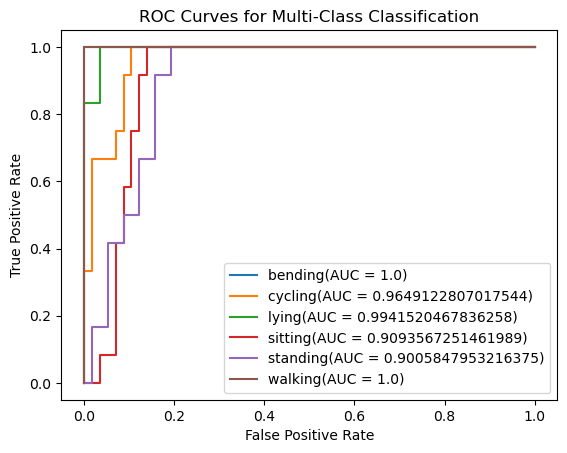

In [48]:
from sklearn.metrics import auc, roc_curve
fpr = {}
tpr = {}
roc_auc = {}


y_score = log_reg.decision_function(X_train)
y_encoding = pd.get_dummies(y_train)
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_encoding.values[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
for i in range(6):
    plt.plot(fpr[i], tpr[i], label = act_list[i] + '(AUC = ' + str(roc_auc[i]) + ')')

plt.title('ROC Curves for Multi-Class Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')

#### ii. Naive Bayes

In [50]:
#Gaussian
best_score = -math.inf
best_l = 0
for L in range(1,21):
    selected_col=[]
    DF = get_df_for_each_instance(L)
    DF.reset_index(drop=True, inplace=True)

    result = pd.concat([DF,yyy_train], axis =1)
    ordered_col = ['max','mean','std']
    
    # reset the index to be readable
    for i in range(1,7):
        for item in ordered_col:
            for v in range(1,L+1):
                selected_col.append(f'{item}{i}_{v}')
    
    X_train = result.iloc[:, :-1]
    y_train = result.iloc[:, -1]
    
    model = GaussianNB()
    Gaussian_model = model.fit(X_train, y_train) 
    score = Gaussian_model.score(X_train, y_train)
    print(f'for L = {L}, the score is {score}')

    if score > best_score:
        best_score = score 
        best_l = L
        
print(f'The best_L for this Gaussian model is {best_l}, the best score is {best_score}, so that the test error is {1-best_score}')

for L = 1, the score is 0.9710144927536232
for L = 2, the score is 0.9855072463768116
for L = 3, the score is 0.9855072463768116
for L = 4, the score is 0.9855072463768116
for L = 5, the score is 0.9855072463768116
for L = 6, the score is 0.9855072463768116
for L = 7, the score is 0.9855072463768116
for L = 8, the score is 0.9855072463768116
for L = 9, the score is 0.9855072463768116
for L = 10, the score is 0.9710144927536232
for L = 11, the score is 0.9855072463768116
for L = 12, the score is 0.9855072463768116
for L = 13, the score is 0.9855072463768116
for L = 14, the score is 0.9855072463768116
for L = 15, the score is 0.9855072463768116
for L = 16, the score is 0.9855072463768116
for L = 17, the score is 0.9855072463768116
for L = 18, the score is 0.9855072463768116
for L = 19, the score is 0.9855072463768116
for L = 20, the score is 0.9855072463768116
The best_L for this Gaussian model is 2, the best score is 0.9855072463768116, so that the test error is 0.01449275362318836


In [56]:
#refit
selected_col=[]
DF = get_df_for_each_instance(best_l)
DF.reset_index(drop=True, inplace=True)
result = pd.concat([DF,yyy_train], axis =1)
X_train = result.iloc[:, :-1]
y_train = result.iloc[:, -1]

#confusion
model = GaussianNB()
Gaussian_model = model.fit(X_train, y_train)
y_pred_train = Gaussian_model.predict(X_train)
print('confusion matrix for train:')
print(confusion_matrix(y_train, y_pred_train))

DF = get_df_for_each_instance_test(best_l)
DF.reset_index(drop=True, inplace=True)
result = pd.concat([DF,yyy_test], axis =1)
X_test = result.iloc[:, :-1]
y_test = result.iloc[:, -1]
y_pred_test = Gaussian_model.predict(X_test)
print('confusion matrix for test:')
print(confusion_matrix(y_test, y_pred_test))

confusion matrix for train:
[[ 8  0  1  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  0  0 12]]
confusion matrix for test:
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [1 0 2 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]


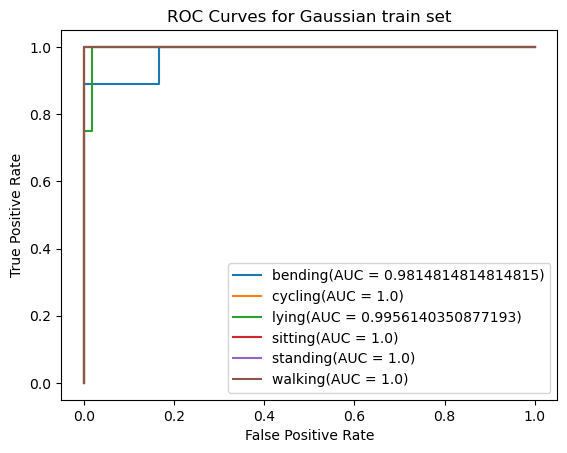

In [53]:
# ROC Curves for Gaussian train set
fpr = {}
tpr = {}
roc_auc = {}

y_score = Gaussian_model.predict_proba(X_train)
y_encoding = pd.get_dummies(y_train)
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_encoding.values[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
for i in range(6):
    plt.plot(fpr[i], tpr[i], label = act_list[i] + '(AUC = ' + str(roc_auc[i]) + ')')

plt.title('ROC Curves for Gaussian train set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')

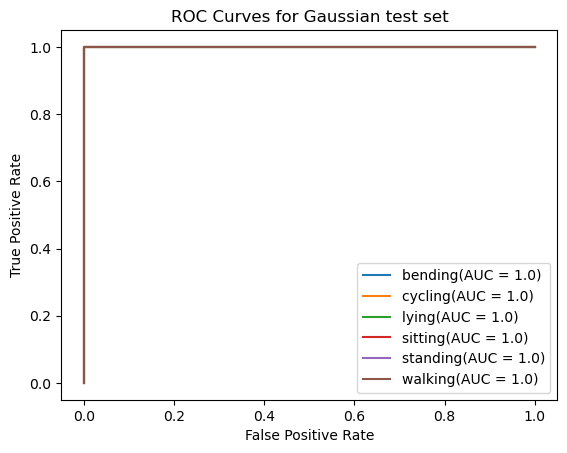

In [54]:
# ROC Curves for Gaussian test set


fpr = {}
tpr = {}
roc_auc = {}

y_score = Gaussian_model.predict_proba(X_test)
y_encoding = pd.get_dummies(y_test)
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_encoding.values[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
for i in range(6):
    plt.plot(fpr[i], tpr[i], label = act_list[i] + '(AUC = ' + str(roc_auc[i]) + ')')

plt.title('ROC Curves for Gaussian test set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')

In [55]:
# Multi
best_score = -math.inf
best_l = 0
for L in range(1,21):
    selected_col=[]
    DF = get_df_for_each_instance(L)
    DF.reset_index(drop=True, inplace=True)

    result = pd.concat([DF,yyy_train], axis =1)
    ordered_col = ['max','mean','std']
    
    # reset the index to be readable
    for i in range(1,7):
        for item in ordered_col:
            for v in range(1,L+1):
                selected_col.append(f'{item}{i}_{v}')
    
    X_train = result.iloc[:, :-1]
    y_train = result.iloc[:, -1]
    
    model = MultinomialNB()
    multi_model = model.fit(X_train, y_train) 
    score = multi_model.score(X_train, y_train)
    print(f'for L = {L}, the score is {score}')

    if score > best_score:
        best_score = score 
        best_l = L
        
print(f'The best_L for this Multinomial model is {best_l}, the best score is {best_score}, so that the test error is {1-best_score}')

for L = 1, the score is 0.8840579710144928
for L = 2, the score is 0.9420289855072463
for L = 3, the score is 0.9420289855072463
for L = 4, the score is 0.9565217391304348
for L = 5, the score is 0.927536231884058
for L = 6, the score is 0.927536231884058
for L = 7, the score is 0.9565217391304348
for L = 8, the score is 0.9420289855072463
for L = 9, the score is 0.9565217391304348
for L = 10, the score is 0.9420289855072463
for L = 11, the score is 0.9710144927536232
for L = 12, the score is 0.9710144927536232
for L = 13, the score is 0.9710144927536232
for L = 14, the score is 0.9710144927536232
for L = 15, the score is 0.9710144927536232
for L = 16, the score is 0.9710144927536232
for L = 17, the score is 0.9710144927536232
for L = 18, the score is 0.9710144927536232
for L = 19, the score is 0.9710144927536232
for L = 20, the score is 0.9710144927536232
The best_L for this Multinomial model is 11, the best score is 0.9710144927536232, so that the test error is 0.02898550724637683


In [57]:
#refit
selected_col=[]
DF = get_df_for_each_instance(best_l)
DF.reset_index(drop=True, inplace=True)
result = pd.concat([DF,yyy_train], axis =1)
X_train = result.iloc[:, :-1]
y_train = result.iloc[:, -1]

#confusion
model = MultinomialNB()
multi_model = model.fit(X_train, y_train) 
y_pred = multi_model.predict(X_train)
y_pred_train = multi_model.predict(X_train)
print('confusion matrix for train:')
print(confusion_matrix(y_train, y_pred_train))

DF = get_df_for_each_instance_test(best_l)
DF.reset_index(drop=True, inplace=True)
result = pd.concat([DF,yyy_test], axis =1)
X_test = result.iloc[:, :-1]
y_test = result.iloc[:, -1]
y_pred_test = multi_model.predict(X_test)
print('confusion matrix for test:')
print(confusion_matrix(y_test, y_pred_test))


confusion matrix for train:
[[ 9  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 1  0  0 11  0  0]
 [ 0  0  0  1 11  0]
 [ 0  0  0  0  0 12]]
confusion matrix for test:
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]


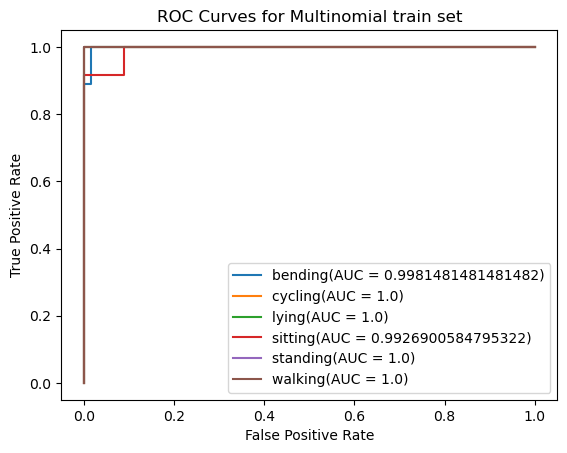

In [58]:
# ROC Curves for Multinomial train set
fpr = {}
tpr = {}
roc_auc = {}

y_score = multi_model.predict_proba(X_train)
y_encoding = pd.get_dummies(y_train)
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_encoding.values[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
for i in range(6):
    plt.plot(fpr[i], tpr[i], label = act_list[i] + '(AUC = ' + str(roc_auc[i]) + ')')

plt.title('ROC Curves for Multinomial train set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')

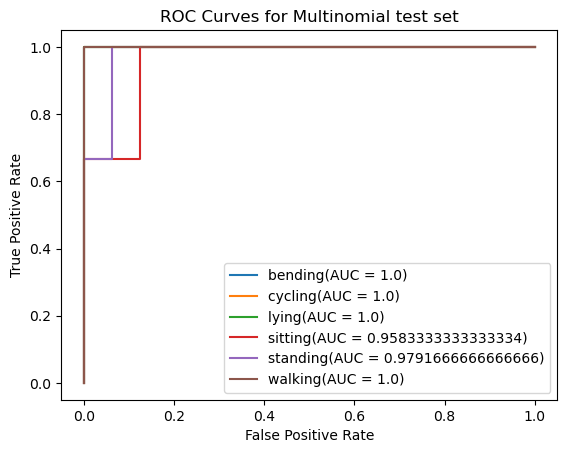

In [59]:
# ROC Curves for Multinomial test set

fpr = {}
tpr = {}
roc_auc = {}

y_score = multi_model.predict_proba(X_test)
y_encoding = pd.get_dummies(y_test)
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_encoding.values[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
for i in range(6):
    plt.plot(fpr[i], tpr[i], label = act_list[i] + '(AUC = ' + str(roc_auc[i]) + ')')

plt.title('ROC Curves for Multinomial test set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')

#### ii. Comparison

Gaussian model is better since it has higher accuracy.